In [53]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [54]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')

['meddra',
 'meddra - unedited version of edited files',
 'original',
 'original - unedited version of edited files',
 'sct',
 'sct - unedited version of edited files',
 'text']

In [55]:
suf = '_v3'

data_save_dir = 'data'+suf

In [56]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [57]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [58]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [59]:
len(docs)

1186

In [60]:
temp = docs[433]
temp.to_plain_string

<bound method Sentence.to_plain_string of Sentence[157]: "wow , so im not crazy after all ! my dr cant seem to find out why my feet hurt in the morning and unexplained joint pain , i get even after just sitting for an hour watching tv in the evening . man i get up and i can hardly walk . stiffness in my feet , and leg joint . dr has done x - ray and everything . im think he is thinking it is in my head all this pain . now when i so called sleep at night i have been noticing i get numbness in my hands , and it isnt due to me lying on my arms or anything , and my lt wrist joint , where my thumb is attached , is dislocating or it painfully sticks . and i have to painfully put it back in . im going to show this website to my gp ! ." → ["wow"/O/O, ","/O/O, "so"/O/O, "im"/O/O, "not"/O/O, "crazy"/O/O, "after"/O/O, "all"/O/O, "!"/O/O, "my"/O/O, "dr"/O/O, "cant"/O/O, "seem"/O/O, "to"/O/O, "find"/O/O, "out"/O/O, "why"/O/O, "my"/O/O, "feet"/B-ADR/B-Foot_pain, "hurt"/I-ADR/I-Foot_pain, "in"/O/O, "

In [61]:
temp.annotation_layers

{'ner': ['Token[0]: "wow"'/'O' (1.0),
  'Token[1]: ","'/'O' (1.0),
  'Token[2]: "so"'/'O' (1.0),
  'Token[3]: "im"'/'O' (1.0),
  'Token[4]: "not"'/'O' (1.0),
  'Token[5]: "crazy"'/'O' (1.0),
  'Token[6]: "after"'/'O' (1.0),
  'Token[7]: "all"'/'O' (1.0),
  'Token[8]: "!"'/'O' (1.0),
  'Token[9]: "my"'/'O' (1.0),
  'Token[10]: "dr"'/'O' (1.0),
  'Token[11]: "cant"'/'O' (1.0),
  'Token[12]: "seem"'/'O' (1.0),
  'Token[13]: "to"'/'O' (1.0),
  'Token[14]: "find"'/'O' (1.0),
  'Token[15]: "out"'/'O' (1.0),
  'Token[16]: "why"'/'O' (1.0),
  'Token[17]: "my"'/'O' (1.0),
  'Token[18]: "feet"'/'B-ADR' (1.0),
  'Token[19]: "hurt"'/'I-ADR' (1.0),
  'Token[20]: "in"'/'O' (1.0),
  'Token[21]: "the"'/'O' (1.0),
  'Token[22]: "morning"'/'O' (1.0),
  'Token[23]: "and"'/'O' (1.0),
  'Token[24]: "unexplained"'/'O' (1.0),
  'Token[25]: "joint"'/'B-ADR' (1.0),
  'Token[26]: "pain"'/'I-ADR' (1.0),
  'Token[27]: ","'/'O' (1.0),
  'Token[28]: "i"'/'O' (1.0),
  'Token[29]: "get"'/'O' (1.0),
  'Token[30]: "eve

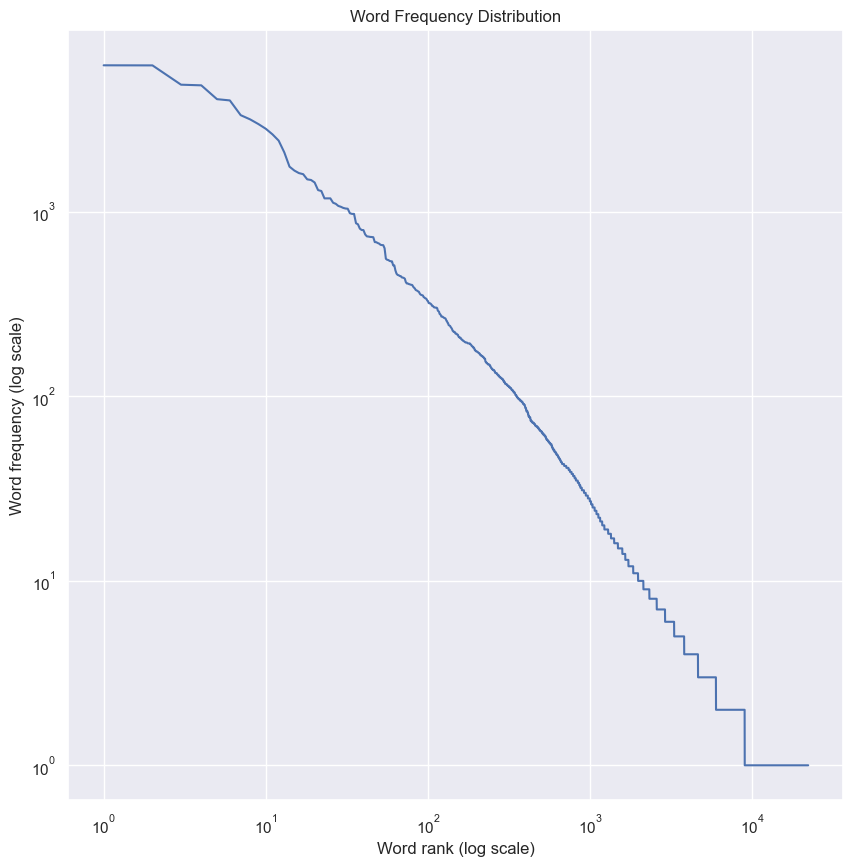

In [62]:
# # import seaborn as sns
# import matplotlib.pyplot as plt
# from collections import Counter
# from itertools import chain
# # from flair.data import Sentence

# Assume that you have a list of Flair Sentence objects called 'sentences'
text = ' '.join([str(sentence) for sentence in docs])
words = text.split()
word_freq = Counter(words)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
freqs = [f for w, f in sorted_word_freq]
ranks = range(1, len(sorted_word_freq)+1)

# Set the plot style and scale
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Set1", 8, .75)
sns.set(rc={'figure.figsize':(10,10)})
sns.color_palette("tab10")

# Create the plot
sns.lineplot(x=ranks, y=freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Word rank (log scale)')
plt.ylabel('Word frequency (log scale)')
plt.title('Word Frequency Distribution')

# Show the plot
plt.show()


In [63]:
def get_all_labels(token):
    res = dict()
    for typename in token.sentence.annotation_layers.keys():
        res[typename] = [a for a in token.sentence.annotation_layers[typename] if a.data_point.start_position == token.start_position]
    return res

In [64]:
train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

In [65]:
# get all unique ner tags, excluding leading conll ordering term
ner_tags = []
for doc in train_docs:
    for token in doc:
        labels = get_all_labels(token)
        if "ner" in labels:
            for label in labels["ner"]:
                ner_tags.append(label.value)

# get all unique meddra tags, excluding leading conll ordering term
meddra_tags = []
for doc in train_docs:
    for token in doc:
        labels = get_all_labels(token)
        if "meddra" in labels:
            for label in labels["meddra"]:
                meddra_tags.append(label.value)
ner_tags = Counter(ner_tags)
del ner_tags['O']
meddra_tags = Counter(meddra_tags)
del meddra_tags['O']

ner_tags_ordered = [a[0] for a in ner_tags.most_common()]
meddra_tags_ordered = [a[0] for a in meddra_tags.most_common()]

print("Unique NER tags:", ner_tags)
print("Unique Meddra tags:", meddra_tags)


Unique NER tags: Counter({'I-ADR': 7953, 'B-ADR': 4712, 'B-Drug': 1396, 'I-Finding': 349, 'B-Finding': 309, 'B-Disease': 231, 'B-Symptom': 222, 'I-Symptom': 218, 'I-Disease': 169, 'I-Drug': 161})
Unique Meddra tags: Counter({'B-Lipitor': 825, 'I-CONCEPT_LESS': 746, 'I-Severe_pain': 425, 'B-CONCEPT_LESS': 351, 'I-Myalgia': 296, 'B-Pain': 290, 'B-Myalgia': 210, 'I-Muscle_weakness': 152, 'B-Severe_pain': 138, 'I-Arthralgia': 137, 'I-Walking_disability': 127, 'I-Cramp_in_lower_limb': 115, 'I-Pain_in_lower_limb': 115, 'I-Hip_pain': 114, 'B-Fatigue': 112, 'B-Arthralgia': 109, 'B-Muscle_cramp': 104, 'I-Shoulder_pain': 103, 'I-Pins_and_needles': 103, 'I-Foot_pain': 102, 'I-Backache': 101, 'I-Weakness_of_limb': 101, 'B-Depression': 98, 'I-Knee_pain': 94, 'I-Poor_short-term_memory': 93, 'B-Excessive_upper_gastrointestinal_gas': 92, 'B-Headache': 88, 'I-Excessive_upper_gastrointestinal_gas': 86, 'I-Neck_pain': 85, 'B-Asthenia': 76, 'I-Generalised_aches_and_pains': 75, 'I-Muscle_atrophy': 74, 'I-S

In [66]:
len(ner_tags)

10

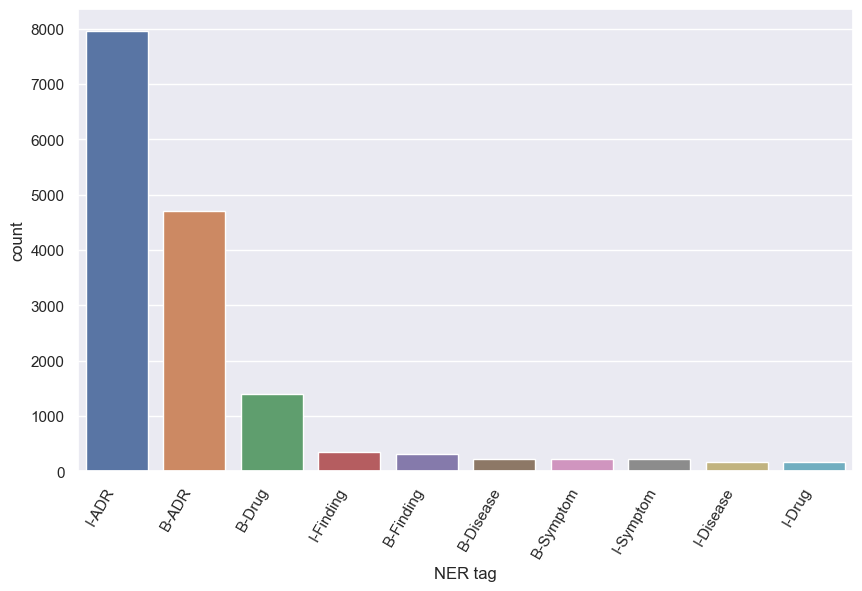

In [67]:
tab = pd.DataFrame([[a, b] for a,b in ner_tags.items()], columns = ['NER tag','count'])
tab = tab.sort_values('count',ascending=False)


sns.set(rc={'figure.figsize':(10,6)})
chart = sns.barplot(tab, x='NER tag',y='count')
chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.show()

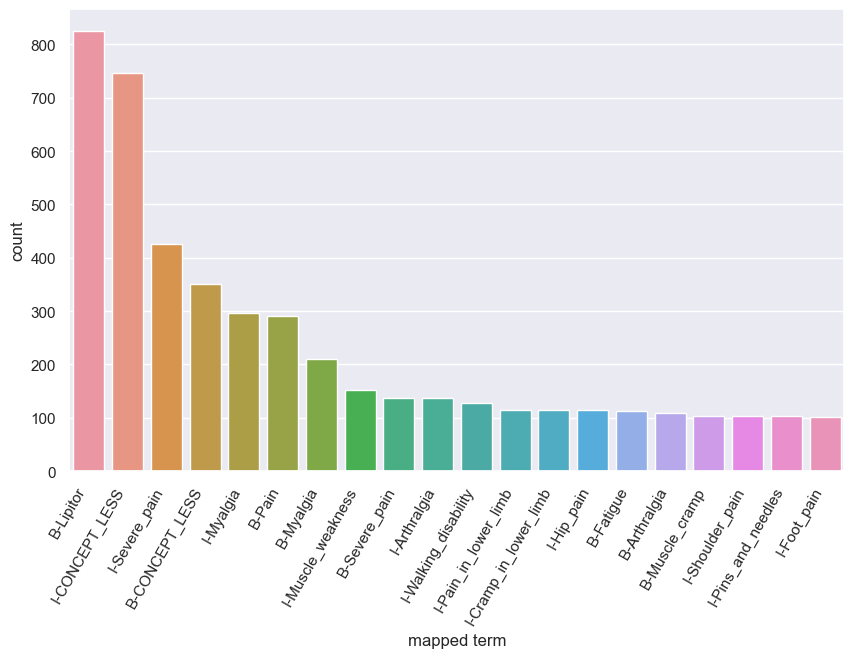

In [68]:
tab = pd.DataFrame([[a, b] for a,b in meddra_tags.items()], columns = ['mapped term','count'])
tab = tab.sort_values('count',ascending=False)

sns.set(rc={'figure.figsize':(10,6)})
chart = sns.barplot(tab[:20], x='mapped term',y='count')
chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.show()

In [69]:
tab

,mapped term,count
6,B-Lipitor,825
49,I-CONCEPT_LESS,746
1,I-Severe_pain,425
43,B-CONCEPT_LESS,351
100,I-Myalgia,296
...,...,...
1302,I-naproxen,1
786,B-Nasal_congestion,1
1304,B-Lyrica,1
1306,B-pseudoephedrine,1


In [70]:
def repeat_arr(lst, n):
    if len(lst) < n:
        lst *= (n // len(lst)) + 1
    return lst

In [71]:
def remove_o_tags(y_true, y_pred):
    # y_true_no_o = []
    # y_pred_no_o = []
    # for true, pred in zip(y_true, y_pred):
    #     if true != 'O':
    #         y_true_no_o.append(true)
    #         y_pred_no_o.append(pred)
    # return y_true_no_o, y_pred_no_o
    
    return y_true, y_pred


## ner - random baseline

## ner - most frequent baseline

In [72]:
res_random = res_mostfreq = pd.DataFrame(columns=['split','index']+ner_tags_ordered)
train=None
for split, split_name in [(train_docs,'train'),(dev_docs,'dev'),(test_docs,'test')]:
    y_true = []
    for doc in tqdm(split, total=len(split)):
        for token in doc:
            labels = get_all_labels(token)
            y_true += [a.value for a in labels['ner']]
            
    if split_name == 'train':
        train = y_true
            
    np.random.seed(1234)
    y_pred = random.sample(repeat_arr(sorted(ner_tags_ordered+['O']), len(y_true)), len(y_true))
    y_true1, y_pred1 = remove_o_tags(y_true, y_pred)
    res = pd.DataFrame.from_dict(classification_report(y_true1, y_pred1, output_dict=True, zero_division=0)).reset_index()
    temp = res['index']
    res.drop('index',axis=1,inplace=True)
    res.insert(loc=0, column='split', value=split_name)
    res.insert(loc=1, column='index', value=temp)
    res_random = pd.concat([res_random, res],ignore_index=True)
    
    mostfreq = ner_tags_ordered[0]
    print(mostfreq)
    y_pred = [mostfreq]*len(y_true)
    y_true1, y_pred1 = remove_o_tags(y_true, y_pred)
    res = pd.DataFrame.from_dict(classification_report(y_true1, y_pred1, output_dict=True, zero_division=0)).reset_index()
    temp = res['index']
    res.drop('index',axis=1,inplace=True)
    res.insert(loc=0, column='split', value=split_name)
    res.insert(loc=1, column='index', value=temp)
    res_mostfreq = pd.concat([res_mostfreq, res],ignore_index=True)

if 'O' in res_random.columns:
    res_random.drop('O',axis=1,inplace=True)
if 'O' in res_mostfreq.columns:
    res_mostfreq.drop('O',axis=1,inplace=True)

res_random = res_random.iloc[:, :res_random.columns.get_loc('weighted avg')+1]
res_mostfreq = res_mostfreq.iloc[:, :res_mostfreq.columns.get_loc('weighted avg')+1]

res_random.to_csv('baseline_ner_model'+suf+'/random_classification_report.csv',index=False)
res_mostfreq.to_csv('baseline_ner_model'+suf+'/mostfreq_classification_report.csv',index=False)

100%|██████████| 948/948 [00:09<00:00, 103.82it/s]


I-ADR


100%|██████████| 119/119 [00:00<00:00, 125.46it/s]


I-ADR


100%|██████████| 119/119 [00:00<00:00, 128.98it/s]


I-ADR


In [73]:
res_random

,split,index,I-ADR,B-ADR,B-Drug,I-Finding,B-Finding,B-Disease,B-Symptom,I-Symptom,I-Disease,I-Drug,accuracy,macro avg,weighted avg
0,train,precision,0.091215,0.050366,0.012071,0.003714,0.003830,0.002437,0.002089,0.001857,0.001973,0.001741,0.091531,0.091530,0.707337
1,train,recall,0.098831,0.092105,0.074499,0.091691,0.106796,0.090909,0.081081,0.073394,0.100592,0.093168,0.091531,0.090375,0.091531
2,train,f1-score,0.094870,0.065121,0.020775,0.007139,0.007394,0.004747,0.004073,0.003623,0.003870,0.003419,0.091531,0.034478,0.148582
3,train,support,7953.000000,4712.000000,1396.000000,349.000000,309.000000,231.000000,222.000000,218.000000,169.000000,161.000000,0.091531,94777.000000,94777.000000
4,dev,precision,0.076592,0.037866,0.015517,0.002584,0.009466,0.003448,0.001721,0.001721,0.002586,0.003442,0.090333,0.090287,0.710685
5,dev,recall,0.092133,0.067588,0.097826,0.055556,0.171875,0.129032,0.080000,0.055556,0.107143,0.148148,0.090333,0.099619,0.090333
6,dev,f1-score,0.083647,0.048538,0.026786,0.004938,0.017945,0.006717,0.003370,0.003339,0.005051,0.006728,0.090333,0.033741,0.146912
7,dev,support,966.000000,651.000000,184.000000,54.000000,64.000000,31.000000,25.000000,36.000000,28.000000,27.000000,0.090333,12775.000000,12775.000000
8,test,precision,0.068966,0.050186,0.013928,0.004647,0.000000,0.002786,0.002788,0.002786,0.000929,0.004647,0.088712,0.088798,0.694846
9,test,recall,0.076525,0.093750,0.068493,0.138889,0.000000,0.150000,0.136364,0.090909,0.083333,0.096154,0.088712,0.093136,0.088712


In [74]:
res_mostfreq

,split,index,I-ADR,B-ADR,B-Drug,I-Finding,B-Finding,B-Disease,B-Symptom,I-Symptom,I-Disease,I-Drug,accuracy,macro avg,weighted avg
0,train,precision,0.083913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083913,0.007628,0.007041
1,train,recall,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083913,0.090909,0.083913
2,train,f1-score,0.154833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083913,0.014076,0.012992
3,train,support,7953.000000,4712.0,1396.0,349.0,309.0,231.0,222.0,218.0,169.0,161.0,0.083913,94777.000000,94777.000000
4,dev,precision,0.075616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075616,0.006874,0.005718
5,dev,recall,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075616,0.090909,0.075616
6,dev,f1-score,0.140601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075616,0.012782,0.010632
7,dev,support,966.000000,651.0,184.0,54.0,64.0,31.0,25.0,36.0,28.0,27.0,0.075616,12775.000000,12775.000000
8,test,precision,0.081700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081700,0.007427,0.006675
9,test,recall,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081700,0.090909,0.081700


## meddra - random baseline

## meddra - most frequent baseline

In [75]:
res_random = res_mostfreq = pd.DataFrame(columns=['split','index']+meddra_tags_ordered)
train=None
for split, split_name in [(train_docs,'train'),(dev_docs,'dev'),(test_docs,'test')]:
    y_true = []
    for doc in tqdm(split, total=len(split)):
        for token in doc:
            labels = get_all_labels(token)
            y_true += [a.value for a in labels['meddra']]
    
    if split_name == 'train':
        train = y_true
    
    np.random.seed(1234)
    y_pred = random.sample(repeat_arr(sorted(meddra_tags_ordered+['O']), len(y_true)), len(y_true))
    y_true1, y_pred1 = remove_o_tags(y_true, y_pred)
    res = pd.DataFrame.from_dict(classification_report(y_true1, y_pred1, output_dict=True, zero_division=0)).reset_index()
    temp = res['index']
    res.drop('index',axis=1,inplace=True)
    res.insert(loc=0, column='split', value=split_name)
    res.insert(loc=1, column='index', value=temp)
    res_random = pd.concat([res_random, res],ignore_index=True)
    
    mostfreq = meddra_tags_ordered[0]
    print(mostfreq)
    y_pred = [mostfreq]*len(y_true)
    y_true1, y_pred1 = remove_o_tags(y_true, y_pred)
    res = pd.DataFrame.from_dict(classification_report(y_true1, y_pred1, output_dict=True, zero_division=0)).reset_index()
    temp = res['index']
    res.drop('index',axis=1,inplace=True)
    res.insert(loc=0, column='split', value=split_name)
    res.insert(loc=1, column='index', value=temp)
    res_mostfreq = pd.concat([res_mostfreq, res],ignore_index=True)

if 'O' in res_random.columns:
    res_random.drop('O',axis=1,inplace=True)
if 'O' in res_mostfreq.columns:
    res_mostfreq.drop('O',axis=1,inplace=True)

res_random = res_random.iloc[:, :res_random.columns.get_loc('weighted avg')+1]
res_mostfreq = res_mostfreq.iloc[:, :res_mostfreq.columns.get_loc('weighted avg')+1]

res_random.to_csv('baseline_meddra_model'+suf+'/random_classification_report.csv',index=False)
res_mostfreq.to_csv('baseline_meddra_model'+suf+'/mostfreq_classification_report.csv',index=False)

100%|██████████| 948/948 [00:08<00:00, 107.54it/s]


B-Lipitor


100%|██████████| 119/119 [00:00<00:00, 139.31it/s]


B-Lipitor


100%|██████████| 119/119 [00:00<00:00, 137.89it/s]


B-Lipitor


In [76]:
list(res_random.columns)

['split',
 'index',
 'B-Lipitor',
 'I-CONCEPT_LESS',
 'I-Severe_pain',
 'B-CONCEPT_LESS',
 'I-Myalgia',
 'B-Pain',
 'B-Myalgia',
 'I-Muscle_weakness',
 'B-Severe_pain',
 'I-Arthralgia',
 'I-Walking_disability',
 'I-Cramp_in_lower_limb',
 'I-Pain_in_lower_limb',
 'I-Hip_pain',
 'B-Fatigue',
 'B-Arthralgia',
 'B-Muscle_cramp',
 'I-Shoulder_pain',
 'I-Pins_and_needles',
 'I-Foot_pain',
 'I-Backache',
 'I-Weakness_of_limb',
 'B-Depression',
 'I-Knee_pain',
 'I-Poor_short-term_memory',
 'B-Excessive_upper_gastrointestinal_gas',
 'B-Headache',
 'I-Excessive_upper_gastrointestinal_gas',
 'I-Neck_pain',
 'B-Asthenia',
 'I-Generalised_aches_and_pains',
 'I-Muscle_atrophy',
 'I-Stomach_ache',
 'I-Mentally_dull',
 'I-Muscle_cramp',
 'B-Cramp_in_lower_limb',
 'B-Backache',
 'I-Low_back_pain',
 'I-Amnesia',
 'I-Influenza-like_illness',
 'B-Diarrhoea',
 'B-Muscle_weakness',
 'B-Amnesia',
 'B-Pain_in_lower_limb',
 'I-Unable_to_walk',
 'B-Hip_pain',
 'I-Pain_in_calf',
 'B-Dizziness',
 'B-Walking_disab

In [77]:
res_random

,split,index,B-Lipitor,I-CONCEPT_LESS,I-Severe_pain,B-CONCEPT_LESS,I-Myalgia,B-Pain,B-Myalgia,I-Muscle_weakness,...,B-Feeling_hopeless,B-Feeling_lonely,B-Poor_self-image,I-Poor_self-image,B-Morbid_thoughts,B-Feels_everything_is_futile,B-Transient_global_amnesia,accuracy,macro avg,weighted avg
0,train,precision,0.0,0.018868,0.018182,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000565,5.791978e-04,0.671798
1,train,recall,0.0,0.001340,0.002353,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000565,5.525076e-04,0.000565
2,train,f1-score,0.0,0.002503,0.004167,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000565,1.421311e-04,0.000988
3,train,support,825.0,746.000000,425.000000,351.0,296.0,290.0,210.0,152.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000565,9.551500e+04,95515.000000
4,dev,precision,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000544,5.479452e-04,0.832478
5,dev,recall,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000544,3.581676e-07,0.000544
6,dev,f1-score,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000544,7.158672e-07,0.001088
7,dev,support,121.0,96.000000,36.000000,44.0,33.0,46.0,26.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000544,1.286400e+04,12864.000000
8,test,precision,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000502,4.650802e-04,0.706418
9,test,recall,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000502,3.306146e-07,0.000502


In [78]:
res_mostfreq

,split,index,B-Lipitor,I-CONCEPT_LESS,I-Severe_pain,B-CONCEPT_LESS,I-Myalgia,B-Pain,B-Myalgia,I-Muscle_weakness,...,B-Feeling_hopeless,B-Feeling_lonely,B-Poor_self-image,I-Poor_self-image,B-Morbid_thoughts,B-Feels_everything_is_futile,B-Transient_global_amnesia,accuracy,macro avg,weighted avg
0,train,precision,0.008637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008637,0.000005,0.000075
1,train,recall,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008637,0.000572,0.008637
2,train,f1-score,0.017127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008637,0.000010,0.000148
3,train,support,825.000000,746.0,425.0,351.0,296.0,290.0,210.0,152.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.008637,95515.000000,95515.000000
4,dev,precision,0.009406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009406,0.000018,0.000088
5,dev,recall,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009406,0.001890,0.009406
6,dev,f1-score,0.018637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009406,0.000035,0.000175
7,dev,support,121.000000,96.0,36.0,44.0,33.0,46.0,26.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009406,12864.000000,12864.000000
8,test,precision,0.010629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010629,0.000020,0.000113
9,test,recall,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010629,0.001859,0.010629
